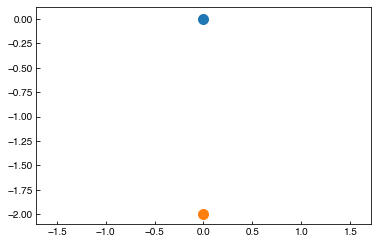

In [624]:
import numpy as np
import numpy as np, scipy.linalg as la
import matplotlib.pyplot as plt

%matplotlib inline


# position and mass of basis (x,y,m)
a = 2 # bond length in ang
mlist = [2,5.1] # mass in 1e-26 kg
Mav = mlist[1]*mlist[0]/(mlist[1]+mlist[0])
conv = np.sqrt(100/Mav)
nx = 1
ny = 1

pos_uc = np.array([[0.0, 0.0, mlist[0]],
                   [0.0, -a, mlist[1]]])

nb = len(pos_uc)
natm = nb * nx * ny

latvec = np.array([[a,a],[a,-a]])
nq1 =120 #0
nq2 = nq1//2
iqstart = int(0.6*nq1)

q11 = np.linspace(2*np.pi/a/2,0,nq1//2,endpoint=False)

little = 0# 1e-6


qq = np.array([np.zeros(nq1//2,),np.linspace(little,np.pi/a/2,nq1//2,endpoint=False)]).ravel()
q3 = np.linspace(np.pi/a/2,2*np.pi/a/2,nq2)
q33 = np.linspace(np.pi/a/2,0,nq2)

q = np.array([q11,np.linspace(little,np.pi/a/2,nq1//2,endpoint=False),q3]).ravel()

#qq = np.linspace(0,np.pi/a/2,nq/2)


qq = np.array([np.zeros(nq1//2,),np.linspace(little,np.pi/a/2,nq1//2,endpoint=False),q33]).ravel()

nq = nq1+nq2

xq = np.zeros(qq.shape)
for i in range(nq-1):
    xq[i+1] = np.sqrt((qq[i+1]-qq[i])**2+(q[i+1]-q[i])**2)+xq[i]

def generate_structure_2d(pos_uc,latvec,nx,ny):
    # diatomic cell
    # number of basis
    nb = pos_uc.shape[0]
    natm = nb * nx * ny
    
    # the atom positions of supercell
    pos = np.zeros((natm,3))
    count = 0
    for i in range(nx):
        for j in range(ny):
            for k in range(nb):
                pos[count,0:2] = pos_uc[k,0:2] + i * latvec[0,:] + j * latvec[1,:]
                pos[count,2] = pos_uc[k,2]
                count += 1
    return pos

def plot_structure(pos,m):
    npos = len(pos)
    nm = len(m)
    
    for i in range(npos):
        for j in range(nm):
            if (abs(float(m[j])-pos[i,2])<0.001):
                plt.scatter(pos[i,0],pos[i,1],c='C'+str(j),s=100)
    
    plt.axis('equal')
                

latvec_sc = np.array([latvec[0,:]*nx,latvec[1,:]*ny])
pos = generate_structure_2d(pos_uc,latvec,nx,ny)
plot_structure(pos,mlist)

def gen_force_constant_supercell(pos,latvec_sc):
    npos = len(pos)
    pos_fc = np.zeros((npos*(2+1)*(2+1),3))
    
    count = 0
    for i in range(-1,2):
        for j in range(-1,2):
            for n in range(npos):
                pos_fc[count,0:2] = pos[n,0:2] \
                   + float(i)*latvec_sc[0,:]\
                   + float(j)*latvec_sc[1,:]
                pos_fc[count,2] = pos[n,2]
                count += 1
    return pos_fc

# we create a 3x3 supercell where central cell is the unit cell of interest
# we calculate dynamical matrix from the force constant
pos_fc = gen_force_constant_supercell(pos,latvec_sc)
#plot_structure(pos_fc,mlist)

# obtain the index of neighboring atoms for a atom
def gen_neighbor_list(pos,nns,latvec_sc):
    npos = len(pos)
    dr = np.zeros((2,))
    
    # neighborlist with dimensions (natm, number of neighbors)
    nlist = np.zeros((npos,nns))
    for i in range(npos):
        count = 0
        for j in range(npos):
            for m in range(-1,2):
                for n in range(-1,2):
                    dr = pos[i,0:2]-pos[j,0:2] +\
                    m* latvec_sc[0,:] + \
                    n* latvec_sc[1,:]
                    if abs(np.sqrt(np.dot(dr,dr))-a)<0.0001:
                        nlist[i,count] = j
                        count += 1
                    elif abs(np.sqrt(np.dot(dr,dr))-np.sqrt(2)*a)<0.0001:
                        nlist[i,count] = j
                        count += 1
    return nlist

def get_force_constant(pos,pos_fc,a):
    
    k1 = 100 # nereast neighbor force constant
    k2 = 100 #50 # second nearest neighbor force constant
    
    # number of atoms in unit cell
    nuc = len(pos)
    nsc = len(pos_fc)
    force_constant = np.zeros((nuc*2,natm*2*(2+1)*(2+1)))
    
    istart = int(1 * (3*nuc) + 1*nuc)
    dr = np.zeros((2,))
    
    for i in range(nuc):
        for j in range(nsc):
            dr = pos_fc[j,0:2] - pos_fc[i+istart,0:2]
            ix = 0 # x
            iy = 0 # x 
            if abs(np.sqrt(np.dot(dr,dr))-a)<0.0001\
                 and abs(dr[1])<0.001:
                force_constant[2*i+ix,2*j+iy] = -k1
            elif abs(np.sqrt(np.dot(dr,dr))-np.sqrt(2)*a)<0.0001:
                force_constant[2*i+ix,2*j+iy] = -k2/2
            ix = 1 # y
            iy = 1 # y 
            if abs(np.sqrt(np.dot(dr,dr))-a)<0.0001\
                 and abs(dr[0])<0.001:
                force_constant[2*i+ix,2*j+iy] = -k1
            elif abs(np.sqrt(np.dot(dr,dr))-np.sqrt(2)*a)<0.0001:
                force_constant[2*i+ix,2*j+iy] = -k2/2
            ix = 0 # x
            iy = 1 # y
            if abs(np.sqrt(np.dot(dr,dr))-np.sqrt(2)*a)<0.0001 \
               and abs(dr[0]+dr[1])<0.001: # north west and south east
                force_constant[2*i+ix,2*j+iy] =  k2/2
            elif abs(np.sqrt(np.dot(dr,dr))-np.sqrt(2)*a)<0.0001 \
               and abs(dr[0]-dr[1])<0.001: # south west and north east
                force_constant[2*i+ix,2*j+iy] = -k2/2
            ix = 1 # y
            iy = 0 # x
            if abs(np.sqrt(np.dot(dr,dr))-np.sqrt(2)*a)<0.0001 \
               and abs(dr[0]+dr[1])<0.001: # north west and south east
                force_constant[2*i+ix,2*j+iy] =  k2/2
            elif abs(np.sqrt(np.dot(dr,dr))-np.sqrt(2)*a)<0.0001 \
               and abs(dr[0]-dr[1])<0.001: # south west and north east
                force_constant[2*i+ix,2*j+iy] = -k2/2
    
    # acoustic sum rule
    for i in range(nuc):
        for ix in range(2):
            for iy in range(2):
                force_constant[2*i+ix,2*(istart+i)+iy] = -(np.sum(force_constant[2*i+ix,iy::2])-force_constant[2*i+ix,2*(istart+i)+iy])
    #print(force_constant.shape)
    #fig, axs = plt.subplots(ncols=1,figsize=(16,16))
    #matshow(axs,force_constant,title='$fc$') 
    
    return force_constant
    
    



# find the neighbor list for each atom
nlist = gen_neighbor_list(pos,8,latvec_sc)
force_constant = get_force_constant(pos,pos_fc,a)

# calculate the dynamical matrix
def gen_dyn(force_constant,pos,pos_fc,q1):
    npos = len(pos)
    nd = 2*npos
    dyn = np.zeros((nd,nd),dtype=complex)
    nuc = len(pos)
    nsc = len(pos_fc)
    # central unit celll
    istart = int(1 * (3*nuc) + 1*nuc)

    for i in range(nuc):
        for j in range(nsc):
            for ix in range(2):
                for iy in range(2):
                    dyn[2*i+ix,2*np.mod(j,nuc)+iy] += \
                    force_constant[2*i+ix,2*j+iy]*\
                    np.exp(1j*(np.dot(q1,pos_fc[j,0:2]-pos_fc[istart+i,0:2])))\
                    /np.sqrt(pos[i,2]*pos[np.mod(j,nuc),2])
                    #print(pos[i,2]*pos[np.mod(j,nuc),2])
    #fig, axs = plt.subplots(ncols=1,figsize=(4,4))
    #matshow(axs,dyn.real,title='$fc$')

    return dyn

def gen_v1(force_constant,pos,pos_fc,q1):
    npos = len(pos)
    nd = 2*npos
    vel = np.zeros((2,nd,nd),dtype=complex)
    vs = np.zeros((2,nd,nd),dtype=complex)
    dyn = np.zeros((nd,nd),dtype=complex)
    nuc = len(pos)
    nsc = len(pos_fc)
    # central unit celll
    istart = int(1 * (3*nuc) + 1*nuc)

    for i in range(nuc):
        for j in range(nsc):
            for ix in range(2):
                for iy in range(2):
                    dyn[2*i+ix,2*np.mod(j,nuc)+iy] += \
                    force_constant[2*i+ix,2*j+iy]*\
                    np.exp(1j*(np.dot(q1,pos_fc[j,0:2]-pos_fc[istart+i,0:2])))\
                    /np.sqrt(pos[i,2]*pos[np.mod(j,nuc),2])
                    for l in range(2):
                        vel[l,2*i+ix,2*np.mod(j,nuc)+iy] += \
                        force_constant[2*i+ix,2*j+iy]*\
                        1j*(pos_fc[j,l]-pos_fc[istart+i,l])*\
                        np.exp(1j*(np.dot(q1,pos_fc[j,0:2]-pos_fc[istart+i,0:2])))\
                        /np.sqrt(pos[i,2]*pos[np.mod(j,nuc),2])
    #print(vel[0,:,:])
    dyn[:,:] = 0.5*(dyn[:,:]+np.transpose(dyn[:,:].conj()))
    vel[0,:,:] = 0.5*(vel[0,:,:]+np.transpose(vel[0,:,:].conj()))
    vel[1,:,:] = 0.5*(vel[1,:,:]+np.transpose(vel[1,:,:].conj()))

    [w,v] = la.eig(dyn)
    idx = np.argsort(w)
    w[:] = w[idx]
    v[:,:] = v[:,idx]
    #print(v)
    #print(vel[:,:,0]-vel[:,:,0].conj())
    #print(v[1,3]/abs(v[1,3]))
    #print(vel[:,:,1]-np.transpose(vel[:,:,1].conj()))
    #fig, axs = plt.subplots(ncols=1,figsize=(4,4))
    #matshow(axs,dyn.real,title='$fc$')
    for l in range(2): 
        for i in range(nd):
            for j in range(nd):
                vs[l,i,j] = np.dot(v[:,i].conj(),np.dot(vel[l,:,:],v[:,j]))\
                /2/np.sqrt(np.sqrt(abs(w[i]))*np.sqrt(abs(w[j])))
                #if i==j:
                    #print(vs[l,i,j])

    #print('in',vs[0,0,0])
    return vs,v,np.sqrt(abs(w)),vel # /1e-26)/2/np.pi/1e12

def rot_ev(ev):
    ev1 = np.zeros(ev.shape,dtype=complex)
    ev1[0] =  np.sqrt(2)/2*(ev[0]+ev[1])
    ev1[1] = -np.sqrt(2)/2*(ev[0]-ev[1])
    ev1[2] = np.sqrt(2)/2*(ev[2]+ev[3])
    ev1[3] = -np.sqrt(2)/2*(ev[2]-ev[3])
    return ev1

def rot_ev_M(ev0,ev1):
    ev2 = np.zeros(ev0.shape,dtype=complex)
    ev3 = np.zeros(ev1.shape,dtype=complex)
    ev2 = np.sqrt(2)/2*(ev0 + ev1)
    ev3 = np.sqrt(2)/2*(ev0 - ev1)
    return ev2,ev3

def plt_ev_conv(ttl,v1,v2,v3,v4,q1,q2,lbs):
    ttl1 = ttl
    u1 = rot_ev(v1)
    u2 = rot_ev(v2)
    plot_ev(mlist,np.array([q1,q2]),u1.real)
    plt.title(r'$'+ttl1+'_'+str(lbs[0])+'$, '+'TA')
    plt.savefig(ttl1+str(lbs[0])+'TA.png',dpi=260)
    plot_ev(mlist,np.array([q1,q2]),u2.real)
    plt.title(r'$'+ttl1+'_'+str(lbs[1])+'$, '+'LA')  
    plt.savefig(ttl1+str(lbs[1])+'LA.png',dpi=260)
    u1 = rot_ev(v3)    
    u2 = rot_ev(v4)
    if ttl!='\Sigma':
        plot_ev(mlist,np.array([q1,q2]),u1.real)
        plt.title(r'$'+ttl1+'_'+str(lbs[2])+'$, '+'TO')
        plt.savefig(ttl1+str(lbs[2])+'TO.png',dpi=260)
        plot_ev(mlist,np.array([q1,q2]),u2.real)
        plt.title(r'$'+ttl1+'_'+str(lbs[3])+'$, '+'LO')
        plt.savefig(ttl1+str(lbs[3])+'LO.png',dpi=260)
    else:
        plot_ev(mlist,np.array([q1,q2]),u1.real)
        plt.title(r'$'+ttl1+'_'+str(lbs[2])+'$, '+'LO')
        plt.savefig(ttl1+str(lbs[2])+'TO.png',dpi=260)
        plot_ev(mlist,np.array([q1,q2]),u2.real)
        plt.title(r'$'+ttl1+'_'+str(lbs[3])+'$, '+'TO')
        plt.savefig(ttl1+str(lbs[3])+'LO.png',dpi=260)
def gen_v2(ids,force_constant,pos,pos_fc,q1):
    npos = len(pos)
    nd = 2*npos
    vel = np.zeros((2,nd,nd),dtype=complex)
    vs =  np.zeros((2,nd,nd),dtype=complex)
    dyn = np.zeros((nd,nd),dtype=complex)
    nuc = len(pos)
    nsc = len(pos_fc)
    # central unit celll
    istart = int(1 * (3*nuc) + 1*nuc)

    for i in range(nuc):
        for j in range(nsc):
            for ix in range(2):
                for iy in range(2):
                    dyn[2*i+ix,2*np.mod(j,nuc)+iy] += \
                    force_constant[2*i+ix,2*j+iy]*\
                    np.exp(1j*(np.dot(q1,pos_fc[j,0:2]-pos_fc[istart+i,0:2])))\
                    /np.sqrt(pos[i,2]*pos[np.mod(j,nuc),2])
                    for l in range(2):
                        vel[l,2*i+ix,2*np.mod(j,nuc)+iy] += \
                        force_constant[2*i+ix,2*j+iy]*\
                        1j*(pos_fc[j,l]-pos_fc[istart+i,l])*\
                        np.exp(1j*(np.dot(q1,pos_fc[j,0:2]-pos_fc[istart+i,0:2])))\
                        /np.sqrt(pos[i,2]*pos[np.mod(j,nuc),2])
    dyn = 0.5*(dyn+np.transpose(dyn.conj()))
    vel[0,:,:] = 0.5*(vel[0,:,:]+np.transpose(vel[0,:,:].conj()))
    vel[1,:,:] = 0.5*(vel[1,:,:]+np.transpose(vel[1,:,:].conj()))

    [w,v] = la.eigh(dyn)
    idx = np.argsort(w)
    w[:] = w[idx]
    v[:,:] = v[:,idx]
    
    for l in range(2):
        for i in range(nd):
            for j in range(nd): 
                vs[l,i,j] = np.dot(v[:,i].conj(),np.dot(vel[l,:,:],v[:,j]))\
                /2/np.sqrt(np.sqrt(abs(w[i]))*np.sqrt(abs(w[j])))    
    
    u1 = np.zeros((nd,),dtype=complex)
    u2 = np.zeros((nd,),dtype=complex)
    if ids == 0: # M point
        print('M vs')
        print(vs[0,:,:].real)
        print(vs[1,:,:].real)
        print('M vel')
        print(vel[0,:,:].real)
        print(vel[1,:,:].real)
        u1 = rot_ev(v[:,0])
        u2 = rot_ev(v[:,1])
        #u1, u2 = rot_ev_M(u1,u2)
        plot_ev(mlist,np.array([q[ids],qq[ids]]),u1.real)
        plt.title(r'$M_5$, LA')
        plt.savefig('M_5'+str(51)+'TA.png',dpi=260)        
        plot_ev(mlist,np.array([q[ids],qq[ids]]),u2.real)
        plt.title(r'$M_5$, TA')
        plt.savefig('M_5'+str(52)+'LA.png',dpi=260) 
        u1 = rot_ev(v[:,2])
        u2 = rot_ev(v[:,3])
        #u1, u2 = rot_ev_M(u1,u2)
        plot_ev(mlist,np.array([q[ids],qq[ids]]),u1.real)
        plt.title(r'$M_5$, LO')
        plt.savefig('M_5'+str(53)+'TO.png',dpi=260) 
        plot_ev(mlist,np.array([q[ids],qq[ids]]),u2.real)
        plt.title(r'$M_5$, TO')
        plt.savefig('M_5'+str(54)+'LO.png',dpi=260) 
        print(vs[0,:,:])
    if ids == nq1//2: # Gamma point
        print('Gamma vs')
        print(vs[1,:,:])
        print('Gamma vel y')
        print(vel[1,:,:])
        print('Gamma vel x')
        print(vel[1,:,:])
        u1 = rot_ev(v[:,0])
        u2 = rot_ev(v[:,1])
        u1, u2 = rot_ev_M(u1,u2)
        plot_ev(mlist,np.array([q[ids],qq[ids]]),u1.real)
        plt.title(r'$\Gamma_5$, TA')
        plt.savefig('Gamma_5'+str(51)+'TA.png',dpi=260)        
        plot_ev(mlist,np.array([q[ids],qq[ids]]),u2.real)
        plt.title(r'$\Gamma_5$, LA')
        plt.savefig('Gamma_5'+str(52)+'LA.png',dpi=260) 
        u1 = rot_ev(v[:,2])
        u2 = rot_ev(v[:,3])
        u1, u2 = rot_ev_M(u1,u2)
        plot_ev(mlist,np.array([q[ids],qq[ids]]),u1.real)
        plt.title(r'$\Gamma_5$, TO')
        plt.savefig('Gamma_5'+str(53)+'TO.png',dpi=260) 
        plot_ev(mlist,np.array([q[ids],qq[ids]]),u2.real)
        plt.title(r'$\Gamma_5$, LO')
        plt.savefig('Gamma_5'+str(54)+'LO.png',dpi=260)         
    if ids == 40: # Gamma-M 
        print('Gamma M')
        print(w)
        plt_ev_conv('\Sigma',v[:,0],v[:,1],v[:,2],v[:,3],q[ids],qq[ids],np.array([2,1,1,2]))
    
 
    

    
    return vs,v,np.sqrt(abs(w)),vel

def gen_v2_repul(ids,force_constant,pos,pos_fc,q1,evo):
    npos = len(pos)
    nd = 2*npos
    vel = np.zeros((2,nd,nd),dtype=complex)
    vs =  np.zeros((2,nd,nd),dtype=complex)
    dyn = np.zeros((nd,nd),dtype=complex)
    nuc = len(pos)
    nsc = len(pos_fc)
    # central unit celll
    istart = int(1 * (3*nuc) + 1*nuc)

    for i in range(nuc):
        for j in range(nsc):
            for ix in range(2):
                for iy in range(2):
                    dyn[2*i+ix,2*np.mod(j,nuc)+iy] += \
                    force_constant[2*i+ix,2*j+iy]*\
                    np.exp(1j*(np.dot(q1,pos_fc[j,0:2]-pos_fc[istart+i,0:2])))\
                    /np.sqrt(pos[i,2]*pos[np.mod(j,nuc),2])
                    for l in range(2):
                        vel[l,2*i+ix,2*np.mod(j,nuc)+iy] += \
                        force_constant[2*i+ix,2*j+iy]*\
                        1j*(pos_fc[j,l]-pos_fc[istart+i,l])*\
                        np.exp(1j*(np.dot(q1,pos_fc[j,0:2]-pos_fc[istart+i,0:2])))\
                        /np.sqrt(pos[i,2]*pos[np.mod(j,nuc),2])
    dyn = 0.5*(dyn+np.transpose(dyn.conj()))
    for l in range(2):
        vel[l,:,:] = 0.5*(vel[l,:,:]+np.transpose(vel[l,:,:].conj()))
        

    [w,v] = la.eigh(dyn)
    idx = np.argsort(w)
    w[:] = w[idx]
    v[:,:] = v[:,idx]
    #print(round(np.dot(v[:,1].conj(),evo[:,1]),4),round(np.dot(v[:,2].conj(),evo[:,2]),4))

    if not(abs(np.dot(v[:,1].conj(),evo[:,1]))>0.8 and abs(np.dot(v[:,2].conj(),evo[:,2]))>0.8):
        w[1:3] = w[2:0:-1]
        v[:,1:3] = v[:,2:0:-1]
    for l in range(2):
        for i in range(nd):
            for j in range(nd): 
                vs[l,i,j] = np.dot(v[:,i].conj(),np.dot(vel[l,:,:],v[:,j]))\
                /2/np.sqrt(np.sqrt(abs(w[i]))*np.sqrt(abs(w[j])))        
    u1 = np.zeros((nd,),dtype=complex)
    u2 = np.zeros((nd,),dtype=complex)
    if ids == nq1: # X
        plt_ev_conv('X',v[:,0],v[:,1],v[:,2],v[:,3],q[ids],qq[ids],np.array([2,1,3,4]))
        print('X',ids)
        print(rot_ev(v[:,0]).real)
        print(rot_ev(v[:,1]).real)      
        print(rot_ev(v[:,2]).real)
        print(rot_ev(v[:,3]).real)  
        

        print(dyn)
    if ids == int(0.68*nq1): # Gamma X
        plt_ev_conv('\Delta',v[:,0],v[:,1],v[:,2],v[:,3],q[ids],qq[ids],np.array([2,1,2,1]))
        print('Gamma X',ids)
        #print(rot_ev(v[:,0]).real)
        #print(rot_ev(v[:,1]).real)      
        #print(rot_ev(v[:,2]).real)
        #print(rot_ev(v[:,3]).real)   
    if ids == nq1+nq2//2: # X M
        plt_ev_conv('Z',v[:,0],v[:,1],v[:,2],v[:,3],q[ids],qq[ids],np.array([2,1,1,2]))
        #print('X M',ids)
        #print(rot_ev(v[:,0]).real)
        #print(rot_ev(v[:,1]).real)      
        #print(rot_ev(v[:,2]).real)
        #print(rot_ev(v[:,3]).real)  
        
    #if ids == ipick:
    #    print(w)
    #    print(v[:,1])
    #    print(v[:,2])
    #    print(np.dot(v[:,1].conj(),v[:,2]))
    if abs(w[1]-w[2])<1:
        print(ids)
        print(rot_ev(v[:,1]).real)
        print(rot_ev(v[:,2]).real)
        print(np.dot(v[:,1].conj(),v[:,2]))
        u = rot_ev(v[:,1]).real
        #plot_ev(mlist,np.array([q[ids],qq[ids]]),u)
    elif abs(w[1]-w[2])<1.5: # or ids == 810 or ids == 910 or ids == 980:
        print('non mix',ids)
        #print(rot_ev(v[:,1]).real)
        #print(rot_ev(v[:,2]).real)
        #print(np.dot(v[:,1].conj(),v[:,2]))
        print(q[ids],qq[ids])
        
        #plot_ev(mlist,np.array([q[ids],qq[ids]]),rot_ev(v[:,0]).real)
        #u = rot_ev(v[:,1]).real
        #plot_ev(mlist,np.array([q[ids],qq[ids]]),u)
        #u = rot_ev(v[:,2]).real
        #plot_ev(mlist,np.array([q[ids],qq[ids]]),u)
        #plot_ev(mlist,np.array(q[ids],qq[ids]),rot_ev(v[:,1]).real)
        #plot_ev(mlist,np.array([q[ids],qq[ids]]),rot_ev(v[:,3]).real)

    return vs,v,np.sqrt(abs(w)),vel

def cal_phonon(dyn):
    [w,v] = la.eig(dyn)
    return w

def continuous_ev(datav,dataev):
    npt = datav.shape[0]
    signs = np.zeros((dataev.shape[1],))
    dev = np.zeros((dataev.shape[1],),dtype=complex)
    datav1 = np.zeros(datav.shape,dtype=complex)
    dataev1 = np.zeros(dataev.shape,dtype=complex)
    dataev1[:,:,:] = dataev[:,:,:] 
    datav1[:,:,:,:] = datav[:,:,:,:]
    xcheck = np.linspace(0,1,npt-3)
    ycheck = np.zeros(xcheck.shape)
    for i in range(2,npt-1):
        signs[:] = 1.0
        for j in range(dataev1.shape[1]):
            dev[:] = dataev1[i,:,j]-dataev1[i-1,:,j]
            #if np.sqrt(np.dot(dev.conj(),dev))>0.5:
            if j== 0:
                #print(i,j)
                #print(round(np.dot(dataev1[i-1,:,j].conj(),dataev1[i,:,j]),4))
                ycheck[i-2] = np.dot(dataev1[i-1,:,j].conj(),dataev1[i,:,j]).real
            if np.real(np.dot(dataev1[i-1,:,j].conj(),dataev1[i,:,j]))<-0.9:
                #print(round(np.dot(dataev1[i-1,:,j].conj(),dataev1[i,:,j]),4))
                signs[j] = -1
        for j in range(dataev1.shape[1]):
            dataev1[i,:,j] = signs[j]*dataev1[i,:,j]
        for j in range(datav1.shape[2]):
            for k in range(datav1.shape[3]):
                #print(signs[j]*signs[k])
                datav1[i,0,j,k] = signs[j]*datav1[i,0,j,k]*signs[k]
                datav1[i,1,j,k] = signs[j]*datav1[i,1,j,k]*signs[k]
    
    return datav1,dataev1,xcheck,ycheck

def plotting1():

    data = np.zeros((nq,4))
    datav = np.zeros((nq,2,4,4),dtype=complex)
    datavel = np.zeros((nq,2,4,4),dtype=complex)
    dataev = np.zeros((nq,4,4),dtype=complex)
 
    for i in range(nq):
        datav[i,:,:,:],dataev[i,:,:],data[i,:],datavel[i,:,:,:] = gen_v1(force_constant,pos,pos_fc,np.array([q[i],qq[i]])) #/1e-26
        #data[i,:] = np.sort(np.sqrt(w.real)/2/np.pi/1e12) # in THz
    #print(datav[:,0,0,0])
    #datav,dataev = continuous_ev(datav,dataev)
    '''
    plt.figure()
    for i in range(4):
        plt.plot(data[:,i],label=str(i+1))
    plt.legend()

    plt.figure()
    for i in range(4):
        for j in range(4):
            if i == j:
                plt.plot(q[1:], datav[1:,0,i,j].real,label=str(i+1)+str(j+1)) # 'b'
    plt.legend()
    plt.figure()
    for i in range(4):
        for j in range(4):
            if i != j and i == 0:
                plt.plot(q[1:], datav[1:,0,i,j].real,'-',label=str(i+1)+str(j+1)) # 'b'
    plt.legend()
    #plt.figure(figsize=(8,8))
    #for i in range(4):
    #    for j in range(4):
    #        if i == j:
    #            plt.plot(q[1:], datav[1:,i,j,1].real,'b',label=str(i+1)+str(j+1))
    #plt.legend()
    #print(dataev[11,:,:])
    #print(datav[11,:,:,0])
    plt.figure()
    plt.plot(q[1:-2],dataev[1:-2,1,0].real)
    plt.plot(q[1:-2],dataev[1:-2,2,0].real)
    plt.plot(q[1:-2],dataev[1:-2,0,0].real)
    plt.plot(q[1:-2],dataev[1:-2,3,0].real)
    plt.figure()

    plt.plot(q[1:-2],dataev[1:-2,1,1].real)
    plt.plot(q[1:-2],dataev[1:-2,2,1].real)
    plt.plot(q[1:-2],dataev[1:-2,0,1].real)
    plt.plot(q[1:-2],dataev[1:-2,3,1].real)
    plt.figure()

    plt.plot(q[1:-2],dataev[1:-2,1,2].real)
    plt.plot(q[1:-2],dataev[1:-2,2,2].real)
    plt.plot(q[1:-2],dataev[1:-2,0,2].real)
    plt.plot(q[1:-2],dataev[1:-2,3,2].real)
    plt.figure()
    plt.plot(q[1:-2],dataev[1:-2,1,3].real)
    plt.plot(q[1:-2],dataev[1:-2,2,3].real)
    plt.plot(q[1:-2],dataev[1:-2,0,3].real)
    plt.plot(q[1:-2],dataev[1:-2,3,3].real)
    #plt.plot(q,dataev[:,2,0].imag)

    plt.figure()
    plt.plot(q[1:-2],dataev[1:-2,1,0].imag)
    plt.plot(q[1:-2],dataev[1:-2,2,0].imag)
    plt.plot(q[1:-2],dataev[1:-2,0,0].imag)
    plt.plot(q[1:-2],dataev[1:-2,3,0].imag)

    plt.plot(q[1:-2],dataev[1:-2,1,1].imag)
    plt.plot(q[1:-2],dataev[1:-2,2,1].imag)
    plt.plot(q[1:-2],dataev[1:-2,0,1].imag)
    plt.plot(q[1:-2],dataev[1:-2,3,1].imag)

    plt.plot(q[1:-2],dataev[1:-2,1,2].imag)
    plt.plot(q[1:-2],dataev[1:-2,2,2].imag)
    plt.plot(q[1:-2],dataev[1:-2,0,2].imag)
    plt.plot(q[1:-2],dataev[1:-2,3,2].imag)

    plt.plot(q[1:-2],dataev[1:-2,1,3].imag)
    plt.plot(q[1:-2],dataev[1:-2,2,3].imag)
    plt.plot(q[1:-2],dataev[1:-2,0,3].imag)
    plt.plot(q[1:-2],dataev[1:-2,3,3].imag)
    '''
    
 
    return datav,dataev,data,datavel
def plotting2():
    data = np.zeros((nq,4))
    datav = np.zeros((nq,2,4,4),dtype=complex)
    datavel = np.zeros((nq,2,4,4),dtype=complex)
    dataev = np.zeros((nq,4,4),dtype=complex)
    for i in range(nq):
        if i<iqstart:
            datav[i,:,:,:],dataev[i,:,:],data[i,:],datavel[i,:,:,:] \
            = gen_v2(i,force_constant,pos,pos_fc,np.array([q[i],qq[i]])) #/1e-26
        else:
            datav[i,:,:,:],dataev[i,:,:],data[i,:],datavel[i,:,:,:] \
            = gen_v2_repul(i,force_constant,pos,pos_fc,np.array([q[i],qq[i]]),dataev[i-1,:,:])
    #datav[0:nq//2,:,:,:],dataev[0:nq//2,:,:],xx,yy = continuous_ev(datav[0:nq//2,:,:,:],dataev[0:nq//2,:,:])
    datav[:,:,:,:],dataev[:,:,:],xx,yy = continuous_ev(datav[:,:,:,:],dataev[:,:,:])

    #plt.figure()
    #plt.plot(xx,yy)
    #datav[nq//2+1:,:,:,:],dataev[nq//2+1:,:,:],xx,yy = continuous_ev(datav[nq//2+1:,:,:,:],dataev[nq//2+1:,:,:])

    '''
    plt.figure()
    for i in range(4):
        plt.plot(data[:,i],label=str(i+1))
    plt.legend()

    plt.figure()
    for i in range(4):
        for j in range(4):
            if i == j:
                plt.plot(q[1:], datav[1:,0,i,j].real,label=str(i+1)+str(j+1)) # 'b'
    plt.legend()
    plt.figure()
    for i in range(4):
        for j in range(4):
            if i != j and i == 0:
                plt.plot(q[1:], datav[1:,0,i,j].real,'-',label=str(i+1)+str(j+1)) # 'b'
    plt.legend()
    #plt.figure(figsize=(8,8))
    #for i in range(4):
    #    for j in range(4):
    #        if i == j:
    #            plt.plot(q[1:], datav[1:,i,j,1].real,'b',label=str(i+1)+str(j+1))
    #plt.legend()
    #print(dataev[11,:,:])
    #print(datav[11,:,:,0])
    '''
    '''


    plt.figure()
    plt.title('0')
    plt.plot(np.linspace(0,1,nq-3),dataev[1:-2,1,0].real)
    plt.plot(np.linspace(0,1,nq-3),dataev[1:-2,2,0].real)
    plt.plot(np.linspace(0,1,nq-3),dataev[1:-2,0,0].real)
    plt.plot(np.linspace(0,1,nq-3),dataev[1:-2,3,0].real)
    plt.figure()
    plt.title('1')
    plt.plot(np.linspace(0,1,nq-3),dataev[1:-2,1,1].real)
    plt.plot(np.linspace(0,1,nq-3),dataev[1:-2,2,1].real)
    plt.plot(np.linspace(0,1,nq-3),dataev[1:-2,0,1].real)
    plt.plot(np.linspace(0,1,nq-3),dataev[1:-2,3,1].real)
    plt.figure()
    plt.title('2')
    plt.plot(np.linspace(0,1,nq-3),dataev[1:-2,1,2].real,'.')
    plt.plot(np.linspace(0,1,nq-3),dataev[1:-2,2,2].real,'.')
    plt.plot(np.linspace(0,1,nq-3),dataev[1:-2,0,2].real,'.')
    plt.plot(np.linspace(0,1,nq-3),dataev[1:-2,3,2].real,'.')
    xf = np.linspace(0,1,nq-3)
    plt.plot(xf[ipick],dataev[ipick,3,2].real,'o')
    plt.figure()
    plt.title('3')
    plt.plot(np.linspace(0,1,nq-3),dataev[1:-2,1,2].real)
    plt.plot(np.linspace(0,1,nq-3),dataev[1:-2,2,2].real)
    plt.plot(np.linspace(0,1,nq-3),dataev[1:-2,0,2].real)
    plt.plot(np.linspace(0,1,nq-3),dataev[1:-2,3,2].real)   


    plt.plot(q[1:-2],dataev[1:-2,1,2].real)
    plt.plot(q[1:-2],dataev[1:-2,2,2].real)
    plt.plot(q[1:-2],dataev[1:-2,0,2].real)
    plt.plot(q[1:-2],dataev[1:-2,3,2].real)
    plt.figure()

    plt.plot(q[1:-2],dataev[1:-2,1,3].real)
    plt.plot(q[1:-2],dataev[1:-2,2,3].real)
    plt.plot(q[1:-2],dataev[1:-2,0,3].real)
    plt.plot(q[1:-2],dataev[1:-2,3,3].real)
    #plt.plot(q,dataev[:,2,0].imag)

    plt.plot(q[1:-2],dataev[1:-2,1,0].imag)
    plt.plot(q[1:-2],dataev[1:-2,2,0].imag)
    plt.plot(q[1:-2],dataev[1:-2,0,0].imag)
    plt.plot(q[1:-2],dataev[1:-2,3,0].imag)

    plt.plot(q[1:-2],dataev[1:-2,1,1].imag)
    plt.plot(q[1:-2],dataev[1:-2,2,1].imag)
    plt.plot(q[1:-2],dataev[1:-2,0,1].imag)
    plt.plot(q[1:-2],dataev[1:-2,3,1].imag)

    plt.plot(q[1:-2],dataev[1:-2,1,2].imag)
    plt.plot(q[1:-2],dataev[1:-2,2,2].imag)
    plt.plot(q[1:-2],dataev[1:-2,0,2].imag)
    plt.plot(q[1:-2],dataev[1:-2,3,2].imag)

    plt.plot(q[1:-2],dataev[1:-2,1,3].imag)
    plt.plot(q[1:-2],dataev[1:-2,2,3].imag)
    plt.plot(q[1:-2],dataev[1:-2,0,3].imag)
    plt.plot(q[1:-2],dataev[1:-2,3,3].imag)
    '''

    return datav,dataev,data,datavel
#u = np.array([ 0.17244463,  0.11965068, -0.05412019 , 0.97622619])
def plot_ev(m,kq,u):
    plt.figure(figsize=(3,3))
    kqq = np.zeros((2,))
    kqq[0] = np.sqrt(2)/2*(kq[0]+kq[1])
    kqq[1] = -np.sqrt(2)/2*(kq[0]-kq[1])
    pos_uc = np.array([[0.0, 0.0, mlist[0]],
                   [-a*np.sqrt(2)/2, -a*np.sqrt(2)/2, mlist[1]]])
    npos = len(pos_uc)
    nm = len(m)
    latvec = np.array([[np.sqrt(2)*a,0],[0,np.sqrt(2)*a]])
    
    ucloc = np.zeros((2,))
    rdm_phi = 0.2 # random phase
    if np.sqrt(kqq[0]**2+kqq[1]**2)>1e-6:
        plt.arrow(0.0,0.0,1.5*kqq[0],1.5*kqq[1],head_width=0.3,head_length=0.7, fc='r', ec='r')
    for mm in range(-2,3):
        for nn in range(-2,3):
            for i in range(npos):
                for j in range(nm):
                    if (abs(float(m[j])-pos_uc[i,2])<0.001):
                        ucloc[:] = mm*latvec[0,:]+nn*latvec[1,:]
                        plt.scatter(pos_uc[i,0]+mm*latvec[0,0]+nn*latvec[1,0],\
                                    pos_uc[i,1]+mm*latvec[0,1]+nn*latvec[1,1],c='C'+str(j),s=5)
                        if np.sqrt(u[2*j]**2+u[2*j+1]**2)>1e-7:
                            plt.arrow(pos_uc[i,0]+mm*latvec[0,0]+nn*latvec[1,0]\
                                  ,pos_uc[i,1]+mm*latvec[0,1]+nn*latvec[1,1], u[2*j]*np.cos(np.dot(ucloc+pos_uc[i,0:2] ,kqq)+rdm_phi), \
                                    u[2*j+1]*np.cos(np.dot(ucloc+pos_uc[i,0:2] ,kqq)+rdm_phi), head_width=0.4, head_length=0.5, fc='C'+str(j), ec='C'+str(j))

    plt.axis('equal')
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.title(str(kqq))
    plt.ylim([-6,6])
    plt.xlim([-6,6])

M vs
[[ 1.12473900e-16  0.00000000e+00 -3.16663390e-16  0.00000000e+00]
 [ 0.00000000e+00  5.50590283e-16  0.00000000e+00 -1.58331695e-16]
 [-3.16663390e-16  0.00000000e+00  8.91546411e-16  0.00000000e+00]
 [ 0.00000000e+00 -1.58331695e-16  0.00000000e+00  6.48615375e-16]]
[[ 0.00000000e+00 -3.33472180e-16  0.00000000e+00 -3.62630656e-16]
 [-3.33472180e-16  0.00000000e+00  3.62630656e-16  0.00000000e+00]
 [ 0.00000000e+00  3.62630656e-16  0.00000000e+00 -6.01403704e-16]
 [-3.62630656e-16  0.00000000e+00 -6.01403704e-16  0.00000000e+00]]
M vel
[[2.44929360e-14 0.00000000e+00 1.53380715e-14 0.00000000e+00]
 [0.00000000e+00 2.44929360e-14 0.00000000e+00 0.00000000e+00]
 [1.53380715e-14 0.00000000e+00 9.60507293e-15 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.60507293e-15]]
[[0.00000000e+00 2.44929360e-14 0.00000000e+00 0.00000000e+00]
 [2.44929360e-14 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.60507293e-15]
 [0.00000

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:749: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


X vs x
[[1.22464680e-14 1.22464680e-14 1.25244858e+02 0.00000000e+00]
 [1.22464680e-14 1.22464680e-14 0.00000000e+00 0.00000000e+00]
 [1.25244858e+02 0.00000000e+00 4.80253647e-15 4.80253647e-15]
 [0.00000000e+00 0.00000000e+00 4.80253647e-15 4.80253647e-15]]
X vs y
[[1.22464680e-14 1.22464680e-14 0.00000000e+00 0.00000000e+00]
 [1.22464680e-14 1.22464680e-14 0.00000000e+00 1.25244858e+02]
 [0.00000000e+00 0.00000000e+00 4.80253647e-15 4.80253647e-15]
 [0.00000000e+00 1.25244858e+02 4.80253647e-15 4.80253647e-15]]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning

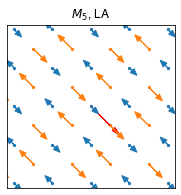

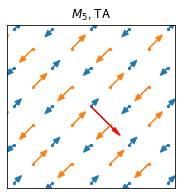

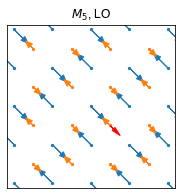

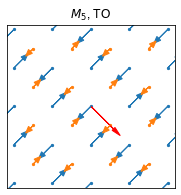

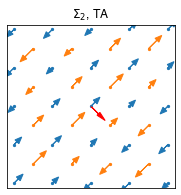

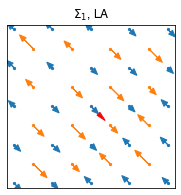

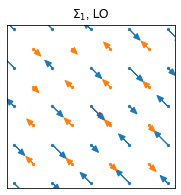

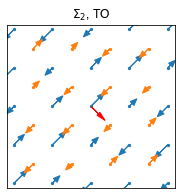

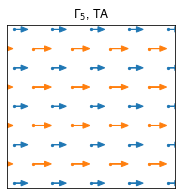

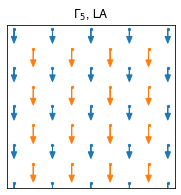

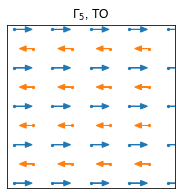

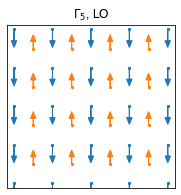

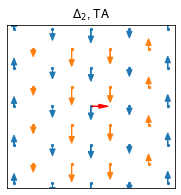

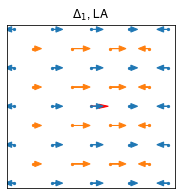

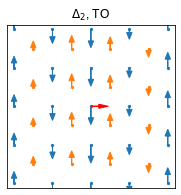

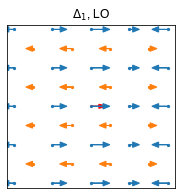

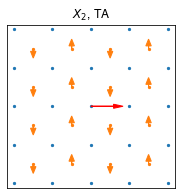

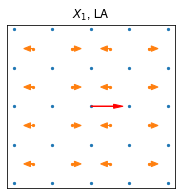

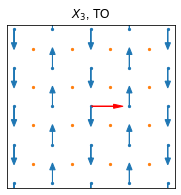

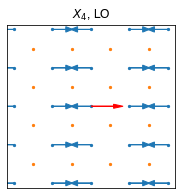

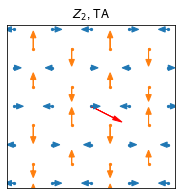

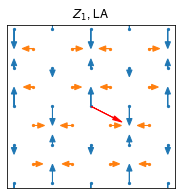

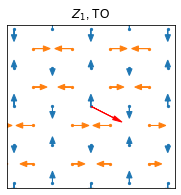

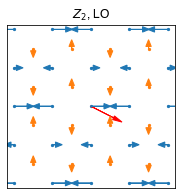

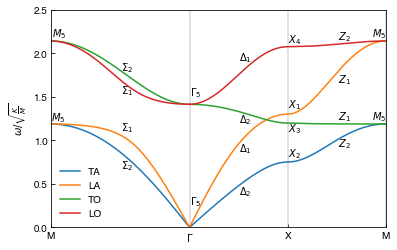

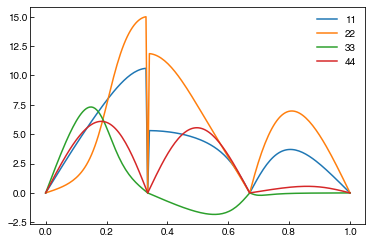

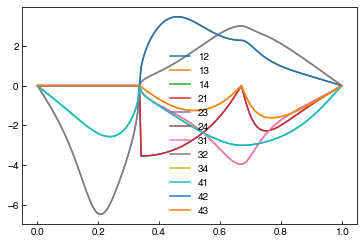

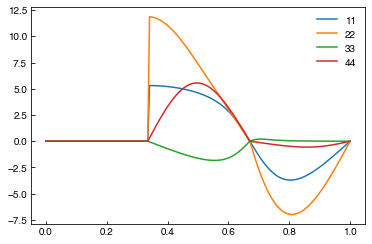

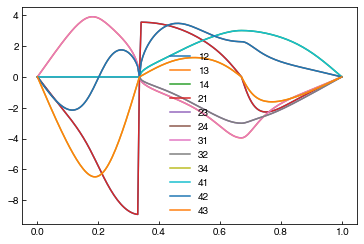

In [626]:
datav1 = np.zeros((nq,2,4,4),dtype=complex)
datav2 = np.zeros((nq,2,4,4),dtype=complex)
datav1,dataev1,d1,dvel1 = plotting1() 
datav2,dataev2,d2,dvel2 = plotting2()


datav3 = np.zeros(dvel2.shape,dtype=complex)

for i in range(datav1.shape[0]):
    for l in range(2):
        for j in range(4):
            for k in range(4):
            #datav3[i,0,j,k] = np.dot(dataev2[i,:,j].conj(),np.dot(dvel2[i,0,:,:],dataev2[i,:,k]))\
            #                /2/np.sqrt(d2[i,j]*d2[i,k])
                #print(np.dot(dataev1[i,:,j].conj(),np.dot(dvel1[i,0,:,:],dataev1[i,:,k]))/2/np.sqrt(d1[i,j]*d1[i,k]))
                datav3[i,l,j,k] = np.dot(dataev1[i,:,j].conj(),np.dot(dvel1[i,l,:,:],dataev1[i,:,k]))\
                            /2/np.sqrt(d1[i,j]*d1[i,k])
plt.figure()
#xq = np.linspace(0,1,nq)

plt.axvline(xq[nq1//2],c='grey',alpha=0.3)
plt.axvline(xq[nq1],c='grey',alpha=0.3)
plt.axvline(xq[nq-1],c='grey',alpha=0.3)
branch_name = ['TA','LA','TO','LO']
d2[0:nq1//2,[3,2]]=d2[0:nq1//2,[2,3]]
for i in range(4):
    plt.plot(xq,d2[:,i]/conv,label=branch_name[i])
# Gamma
plt.text(xq[nq1//2]-0.00, d2[nq1//2,0]/conv+0.26, '$\Gamma_5$')
plt.text(xq[nq1//2]+0.01, d2[nq1//2,2]/conv+0.1, '$\Gamma_5$')
# M
plt.text(xq[0]+0.001, d2[0,0]/conv+0.04, '$M_5$')
plt.text(xq[0]+0.01, d2[0,2]/conv+0.05, '$M_5$')
# M_1
plt.text(xq[-1]-0.16, d2[-1,0]/conv+0.05, '$M_5$')
plt.text(xq[-1]-0.16, d2[-1,1]/conv+0.05, '$M_5$')
# Gamma M
plt.text(xq[nq1//4]+0.01, d2[nq1//4,0]/conv-0.19, '$\Sigma_2$')
plt.text(xq[nq1//4]+0.01, d2[nq1//4,1]/conv+0.05, '$\Sigma_1$')
plt.text(xq[nq1//4]+0.01, d2[nq1//4,2]/conv, '$\Sigma_2$')
plt.text(xq[nq1//4]+0.01, d2[nq1//4,3]/conv-0.15, '$\Sigma_1$')
plt.xticks([xq[0], xq[nq1//2], xq[nq1],xq[nq-1]], ['M', '$\Gamma$', 'X','M'])
plt.ylim([0,2.5])
plt.xlim([0,xq[-1]])
plt.ylabel(r'$\omega/\sqrt{\frac{K}{M}}$')

# X
plt.text(xq[nq1]+0.01, d2[nq1,0]/conv+0.06, '$X_2$')
plt.text(xq[nq1]+0.01, d2[nq1,1]/conv+0.075, '$X_1$')
plt.text(xq[nq1]+0.01, d2[nq1,2]/conv-0.1, '$X_3$')
plt.text(xq[nq1]+0.01, d2[nq1,3]/conv+0.05, '$X_4$')

print('X vs x')
print(dvel1[nq1,0,:,:].real)

print('X vs y')
print(dvel2[nq1,1,:,:].real)

# Gamma X
plt.text(xq[3*nq1//4]+0.01, d2[3*nq1//4,0]/conv-0.1, '$\Delta_2$')
plt.text(xq[3*nq1//4]+0.01, d2[3*nq1//4,1]/conv-0.09, '$\Delta_1$')
plt.text(xq[3*nq1//4]+0.01, d2[3*nq1//4,2]/conv-0.12, '$\Delta_2$')
plt.text(xq[3*nq1//4]+0.01, d2[3*nq1//4,3]/conv+0.17, '$\Delta_1$')
# X M
plt.text(xq[nq1+nq2//2]+0.01, d2[nq1+nq2//2,0]/conv-0.08, '$Z_2$')
plt.text(xq[nq1+nq2//2]+0.01, d2[nq1+nq2//2,1]/conv-0.12, '$Z_1$')
plt.text(xq[nq1+nq2//2]+0.01, d2[nq1+nq2//2,2]/conv+0.05, '$Z_1$')
plt.text(xq[nq1+nq2//2]+0.01, d2[nq1+nq2//2,3]/conv+0.05, '$Z_2$')
plt.legend()
plt.savefig('disp.png',dpi=320)

#for i in range(4):
#    plt.plot(d2[1:nq,i]-d1[0:nq-1,i])
#plt.figure(figsize=(7,7))

#for i in range(4):
#    for j in range(4):
#        #if i != j and i ==1:
#        if i==j:
#            plt.plot(np.linspace(0,1,nq),datav3[:,0,i,j].real,'-',label=str(i+1)+str(j+1)) # 'b'  
#plt.legend()
#plt.figure(figsize=(7,7))
#plt.plot(np.linspace(0,1,nq),datav2[:,0,0,0].real,'.',label=str(i+1)+str(j+1)) # 'b'                

#for i in range(4):
#    for j in range(4):
#        if i == j:
#            plt.plot(np.linspace(0,1,nq),datav1[:,0,i,j].real,label=str(i+1)+str(j+1)) # 'b' 
#plt.figure()
#for i in range(4):
#    plt.plot(np.linspace(0,1,nq),d2[:,i]/conv)
plt.figure()
for i in range(4):
    for j in range(4):
        if i == j:
            #print(datav2[:,1,i,j].real)
            plt.plot(np.linspace(0,1,nq),datav2[:,0,i,j].real,'-',label=str(i+1)+str(j+1)) # 'b'            

plt.legend()

plt.figure()
for i in range(4):
    for j in range(4):
        if i != j:
            #print(datav2[:,1,i,j].real)
            plt.plot(np.linspace(0,1,nq),datav2[:,0,i,j].real,'-',label=str(i+1)+str(j+1)) # 'b'            
plt.legend()


plt.figure()
for i in range(4):
    for j in range(4):
        if i == j:
            #print(datav2[:,1,i,j].real)
            plt.plot(np.linspace(0,1,nq),datav2[:,1,i,j].real,'-',label=str(i+1)+str(j+1)) # 'b'            
plt.legend()

plt.figure()
for i in range(4):
    for j in range(4):
        if i != j:
            #print(datav2[:,1,i,j].real)
            plt.plot(np.linspace(0,1,nq),datav2[:,1,i,j].real,'-',label=str(i+1)+str(j+1)) # 'b'            
plt.legend()
plt.show()
#plt.figure(figsize=(7,7))
#for i in range(4):
#    for j in range(4):
#        if i != j:
#            aa = datav2[:,1,i,j].real
#            plt.plot(np.linspace(0,1,len(aa)),dvel1[:,1,i,j].real,'-',label=str(i+1)+str(j+1)) # 'b'  

def rot_vel(datav):
    n1 = datav.shape[0]
    n2 = datav.shape[1]
    n3 = datav.shape[2]
    datav1 = np.zeros(datav.shape,dtype=complex)
    datav1[:,0,:,:] = np.sqrt(2)/2*(datav[:,0,:,:]+datav[:,1,:,:])
    datav1[:,1,:,:] = -np.sqrt(2)/2*(datav[:,0,:,:]-datav[:,1,:,:])
    return datav1/(conv/(np.pi/a))
datav2= rot_vel(datav2)

[[-5.10489198e-17+0.j  0.00000000e+00+0.j -1.05351505e+00+0.j
   1.18243155e-16+0.j]
 [ 3.18570832e-33+0.j  1.47365538e-16+0.j  1.77364732e-16+0.j
   6.08247200e-01+0.j]
 [-1.05351505e+00+0.j  1.77364732e-16+0.j  3.19680736e-17+0.j
   3.98993587e-32+0.j]
 [ 1.18243155e-16+0.j  6.08247200e-01+0.j  4.05251971e-32+0.j
   1.69802338e-16+0.j]]
[[-5.10489198e-17+0.j  0.00000000e+00+0.j  1.77364732e-16-0.j
   8.00498333e-01-0.j]
 [ 3.18570832e-33-0.j  2.94731076e-17-0.j -8.00498333e-01+0.j
   5.91215773e-17-0.j]
 [ 1.77364732e-16-0.j -8.00498333e-01+0.j -3.19680736e-17+0.j
   7.97987173e-33-0.j]
 [ 8.00498333e-01-0.j  5.91215773e-17-0.j  4.61577426e-33-0.j
   1.84567759e-17-0.j]]


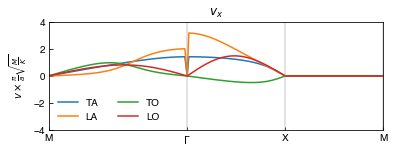

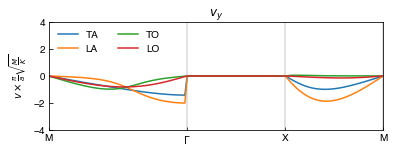

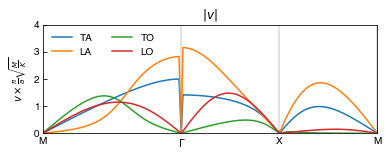

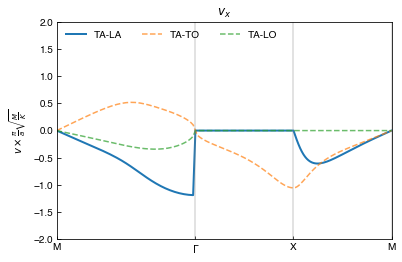

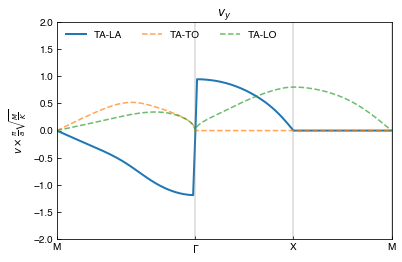

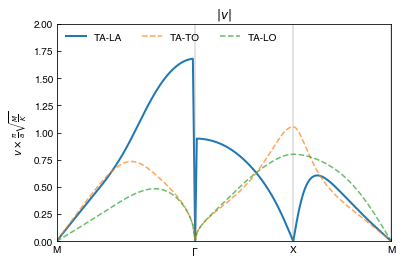

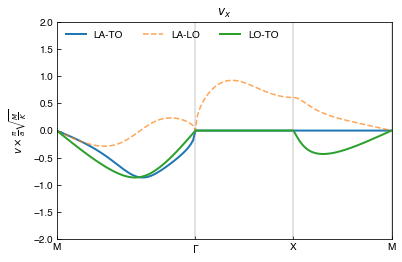

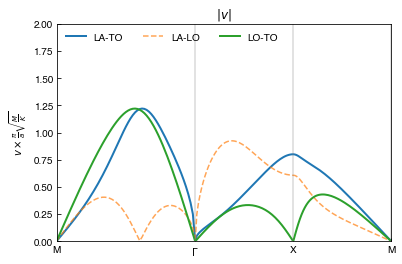

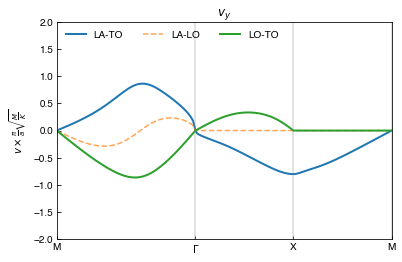

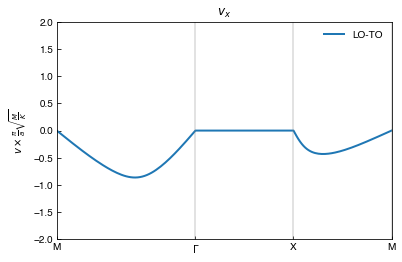

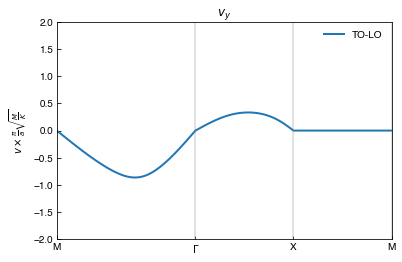

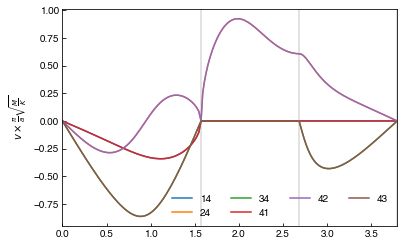

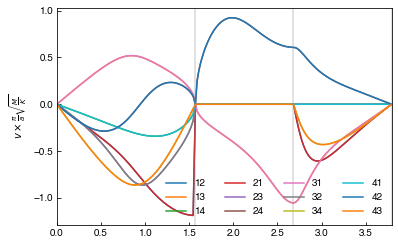

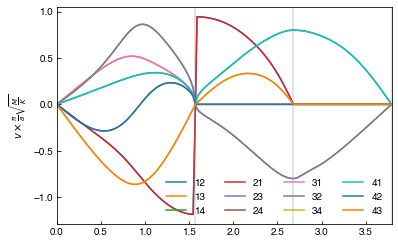

In [641]:
branch_name = ['TA','LA','TO','LO']
plt.figure(figsize=(6,2))
datav22 = np.zeros(datav2.shape,dtype=complex)
datav22[:,:,:,:] = datav2[:,:,:,:]
datav2[0:nq1//2,:,2,:]=datav22[0:nq1//2,:,3,:]
datav2[0:nq1//2,:,3,:]=datav22[0:nq1//2,:,2,:]
datav22[0:nq1//2,:,:] = datav2[0:nq1//2,:,:,:]
datav2[0:nq1//2,:,:,2]=datav22[0:nq1//2,:,:,3]
datav2[0:nq1//2,:,:,3]=datav22[0:nq1//2,:,:,2]


print(datav2[nq1,0,:,:])
print(datav2[nq1,1,:,:])
for i in range(4):
    for j in range(4):
        if i == j:
            #print(datav2[:,1,i,j].real)
            plt.plot(xq,datav2[:,0,i,j].real,'-',label=branch_name[i]) # 'b'            
plt.legend(ncol=2)
plt.ylabel(r'$v \times\frac{\pi}{a}\sqrt{\frac{M}{K}}$')
plt.xlim([0,xq[-1]])
plt.axvline(xq[nq1//2],c='grey',alpha=0.3)
plt.axvline(xq[nq1],c='grey',alpha=0.3)
plt.axvline(xq[nq-1],c='grey',alpha=0.3)
plt.xticks([xq[0], xq[nq1//2], xq[nq1],xq[nq-1]], ['M', '$\Gamma$', 'X','M'])
plt.ylim([-4,4])
plt.title(r'$v_{x}$')
plt.ylabel(r'$v \times\frac{\pi}{a}\sqrt{\frac{M}{K}}$')
plt.savefig('vdiagx.png',dpi=320)
plt.figure(figsize=(6,2))
for i in range(4):
    for j in range(4):
        if i == j:
            #print(datav2[:,1,i,j].real)
            plt.plot(xq,datav2[:,1,i,j].real,'-',label=branch_name[i]) # 'b'            
plt.legend(ncol=2)
plt.xlim([0,xq[-1]])
plt.axvline(xq[nq1//2],c='grey',alpha=0.3)
plt.axvline(xq[nq1],c='grey',alpha=0.3)
plt.axvline(xq[nq-1],c='grey',alpha=0.3)
plt.xticks([xq[0], xq[nq1//2], xq[nq1],xq[nq-1]], ['M', '$\Gamma$', 'X','M'])
plt.ylim([-4,4])
plt.title(r'$v_{y}$')
plt.ylabel(r'$v \times\frac{\pi}{a}\sqrt{\frac{M}{K}}$')
plt.savefig('vdiagy.png',dpi=320)

plt.figure(figsize=(6,2))
for i in range(4):
    for j in range(4):
        if i == j:
            #print(datav2[:,1,i,j].real)
            plt.plot(xq,np.sqrt(datav2[:,0,i,j].real**2+datav2[:,1,i,j].real**2),'-',label=branch_name[i]) # 'b'            
plt.legend(ncol=2)
plt.xlim([0,xq[-1]])
plt.axvline(xq[nq1//2],c='grey',alpha=0.3)
plt.axvline(xq[nq1],c='grey',alpha=0.3)
plt.axvline(xq[nq-1],c='grey',alpha=0.3)
plt.xticks([xq[0], xq[nq1//2], xq[nq1],xq[nq-1]], ['M', '$\Gamma$', 'X','M'])
plt.ylim([0,4])
plt.title(r'$|v|$')
plt.ylabel(r'$v \times\frac{\pi}{a}\sqrt{\frac{M}{K}}$')
plt.savefig('vdiagabs.png',dpi=320)


plt.figure()
i = 0

plt.plot(xq,datav2[:,0,0,1].real,'-',label='TA-LA',lw=2) # 'b'   
plt.plot(xq,datav2[:,0,0,2].real,'--',label='TA-TO',alpha=0.7) # 'b'    
plt.plot(xq,datav2[:,0,0,3].real,'--',label='TA-LO',alpha=0.7) # 'b'    
plt.legend(ncol=4)
plt.axvline(xq[nq1//2],c='grey',alpha=0.3)
plt.axvline(xq[nq1],c='grey',alpha=0.3)
plt.axvline(xq[nq-1],c='grey',alpha=0.3)
plt.xlim([0,xq[-1]])
plt.ylim([-2,2])
plt.title(r'$v_{x}$')
plt.xticks([xq[0], xq[nq1//2], xq[nq1],xq[nq-1]], ['M', '$\Gamma$', 'X','M'])
plt.ylabel(r'$v \times\frac{\pi}{a}\sqrt{\frac{M}{K}}$')
plt.savefig('v11.png',dpi=320)
plt.figure()
i = 0

plt.plot(xq,datav2[:,1,0,1].real,'-',label='TA-LA',lw=2) # 'b'   
plt.plot(xq,datav2[:,1,0,2].real,'--',label='TA-TO',alpha=0.7) # 'b'    
plt.plot(xq,datav2[:,1,0,3].real,'--',label='TA-LO',alpha=0.7) # 'b'    
plt.legend(ncol=4)
plt.axvline(xq[nq1//2],c='grey',alpha=0.3)
plt.axvline(xq[nq1],c='grey',alpha=0.3)
plt.axvline(xq[nq-1],c='grey',alpha=0.3)
plt.xlim([0,xq[-1]])
plt.ylim([-2,2])
plt.title(r'$v_{y}$')
plt.xticks([xq[0], xq[nq1//2], xq[nq1],xq[nq-1]], ['M', '$\Gamma$', 'X','M'])
plt.ylabel(r'$v \times\frac{\pi}{a}\sqrt{\frac{M}{K}}$')

plt.figure()
i = 0

plt.plot(xq,np.sqrt(datav2[:,0,0,1].real**2+datav2[:,1,0,1].real**2),'-',label='TA-LA',lw=2) # 'b'   
plt.plot(xq,np.sqrt(datav2[:,0,0,2].real**2+datav2[:,1,0,2].real**2),'--',label='TA-TO',alpha=0.7) # 'b'    
plt.plot(xq,np.sqrt(datav2[:,0,0,3].real**2+datav2[:,1,0,3].real**2),'--',label='TA-LO',alpha=0.7) # 'b'    
plt.legend(ncol=4)
plt.axvline(xq[nq1//2],c='grey',alpha=0.3)
plt.axvline(xq[nq1],c='grey',alpha=0.3)
plt.axvline(xq[nq-1],c='grey',alpha=0.3)
plt.xlim([0,xq[-1]])
plt.ylim([0,2])
plt.title(r'$|v|$')
plt.xticks([xq[0], xq[nq1//2], xq[nq1],xq[nq-1]], ['M', '$\Gamma$', 'X','M'])
plt.ylabel(r'$v \times\frac{\pi}{a}\sqrt{\frac{M}{K}}$')
plt.savefig('v11abs.png',dpi=320)
plt.figure()
i = 0

plt.plot(xq,datav2[:,0,1,2].real,'-',label='LA-TO',lw=2) # 'b'    
plt.plot(xq,datav2[:,0,1,3].real,'--',label='LA-LO',alpha=0.7) # 'b'    
plt.plot(xq,datav2[:,0,2,3].real,'-',label='LO-TO',lw=2) # 'b' 
plt.legend(ncol=4)
plt.axvline(xq[nq1//2],c='grey',alpha=0.3)
plt.axvline(xq[nq1],c='grey',alpha=0.3)
plt.axvline(xq[nq-1],c='grey',alpha=0.3)
plt.xlim([0,xq[-1]])
plt.ylim([-2,2])
plt.title(r'$v_{x}$')
plt.xticks([xq[0], xq[nq1//2], xq[nq1],xq[nq-1]], ['M', '$\Gamma$', 'X','M'])
plt.ylabel(r'$v \times\frac{\pi}{a}\sqrt{\frac{M}{K}}$')
plt.savefig('v33.png',dpi=320)







plt.figure()
i = 0

plt.plot(xq,np.sqrt(datav2[:,0,1,2].real**2+datav2[:,1,1,2].real**2),'-',label='LA-TO',lw=2) # 'b'    
plt.plot(xq,np.sqrt(datav2[:,0,1,3].real**2+datav2[:,1,1,3].real**2),'--',label='LA-LO',alpha=0.7) # 'b'    
plt.plot(xq,np.sqrt(datav2[:,0,2,3].real**2+datav2[:,1,2,3].real**2),'-',label='LO-TO',lw=2) # 'b' 
plt.legend(ncol=4)
plt.axvline(xq[nq1//2],c='grey',alpha=0.3)
plt.axvline(xq[nq1],c='grey',alpha=0.3)
plt.axvline(xq[nq-1],c='grey',alpha=0.3)
plt.xlim([0,xq[-1]])
plt.ylim([0,2])
plt.title(r'$|v|$')
plt.xticks([xq[0], xq[nq1//2], xq[nq1],xq[nq-1]], ['M', '$\Gamma$', 'X','M'])
plt.ylabel(r'$v \times\frac{\pi}{a}\sqrt{\frac{M}{K}}$')
plt.savefig('v33abs.png',dpi=320)















plt.figure()
i = 0

plt.plot(xq,datav2[:,1,1,2].real,'-',label='LA-TO',lw=2) # 'b'    
plt.plot(xq,datav2[:,1,1,3].real,'--',label='LA-LO',alpha=0.7) # 'b'    
plt.plot(xq,datav2[:,1,2,3].real,'-',label='LO-TO',lw=2) # 'b'  
plt.legend(ncol=4)
plt.axvline(xq[nq1//2],c='grey',alpha=0.3)
plt.axvline(xq[nq1],c='grey',alpha=0.3)
plt.axvline(xq[nq-1],c='grey',alpha=0.3)
plt.xlim([0,xq[-1]])
plt.ylim([-2,2])
plt.title(r'$v_{y}$')
plt.xticks([xq[0], xq[nq1//2], xq[nq1],xq[nq-1]], ['M', '$\Gamma$', 'X','M'])
plt.ylabel(r'$v \times\frac{\pi}{a}\sqrt{\frac{M}{K}}$')

plt.figure()
i = 0

plt.plot(xq,datav2[:,0,2,3].real,'-',label='LO-TO',lw=2) # 'b'    
plt.legend(ncol=4)
plt.axvline(xq[nq1//2],c='grey',alpha=0.3)
plt.axvline(xq[nq1],c='grey',alpha=0.3)
plt.axvline(xq[nq-1],c='grey',alpha=0.3)
plt.xlim([0,xq[-1]])
plt.ylim([-2,2])
plt.title(r'$v_{x}$')
plt.xticks([xq[0], xq[nq1//2], xq[nq1],xq[nq-1]], ['M', '$\Gamma$', 'X','M'])
plt.ylabel(r'$v \times\frac{\pi}{a}\sqrt{\frac{M}{K}}$')

plt.figure()
i = 0

plt.plot(xq,datav2[:,1,2,3].real,'-',label='TO-LO',lw=2) # 'b'    
plt.legend(ncol=4)
plt.axvline(xq[nq1//2],c='grey',alpha=0.3)
plt.axvline(xq[nq1],c='grey',alpha=0.3)
plt.axvline(xq[nq-1],c='grey',alpha=0.3)
plt.xlim([0,xq[-1]])
plt.ylim([-2,2])
plt.title(r'$v_{y}$')
plt.xticks([xq[0], xq[nq1//2], xq[nq1],xq[nq-1]], ['M', '$\Gamma$', 'X','M'])
plt.ylabel(r'$v \times\frac{\pi}{a}\sqrt{\frac{M}{K}}$')
# vij = vji off-diagonal
plt.figure()
for i in range(4):
    for j in range(4):
        if (i==3 or j==3) and i!=j:
            #print(datav2[:,1,i,j].real)
            plt.plot(xq,datav2[:,0,i,j].real,'-',label=str(i+1)+str(j+1)) # 'b'            
plt.legend(ncol=4)
plt.axvline(xq[nq1//2],c='grey',alpha=0.3)
plt.axvline(xq[nq1],c='grey',alpha=0.3)
plt.axvline(xq[nq-1],c='grey',alpha=0.3)
plt.xlim([0,xq[-1]])
plt.ylabel(r'$v \times\frac{\pi}{a}\sqrt{\frac{M}{K}}$')
plt.figure()
for i in range(4):
    for j in range(4):
        if i != j:
            #print(datav2[:,1,i,j].real)
            plt.plot(xq,datav2[:,0,i,j].real,'-',label=str(i+1)+str(j+1)) # 'b'            
plt.legend(ncol=4)
plt.axvline(xq[nq1//2],c='grey',alpha=0.3)
plt.axvline(xq[nq1],c='grey',alpha=0.3)
plt.axvline(xq[nq-1],c='grey',alpha=0.3)
plt.xlim([0,xq[-1]])
plt.ylabel(r'$v \times\frac{\pi}{a}\sqrt{\frac{M}{K}}$')
plt.figure()
for i in range(4):
    for j in range(4):
        if i != j:
            #print(datav2[:,1,i,j].real)
            plt.plot(xq,datav2[:,1,i,j].real,'-',label=str(i+1)+str(j+1)) # 'b'            
plt.legend(ncol=4)
plt.xlim([0,xq[-1]])
plt.axvline(xq[nq1//2],c='grey',alpha=0.3)
plt.axvline(xq[nq1],c='grey',alpha=0.3)
plt.axvline(xq[nq-1],c='grey',alpha=0.3)
plt.ylabel(r'$v \times\frac{\pi}{a}\sqrt{\frac{M}{K}}$')
plt.show()

([<matplotlib.axis.XTick at 0x129f6c950>,
 <a list of 4 Text xticklabel objects>)

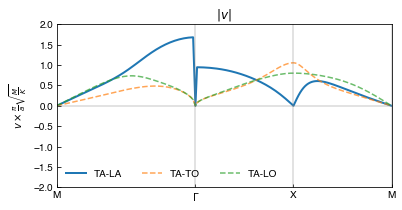

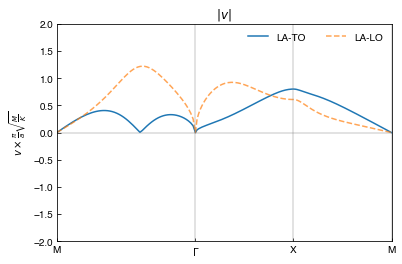

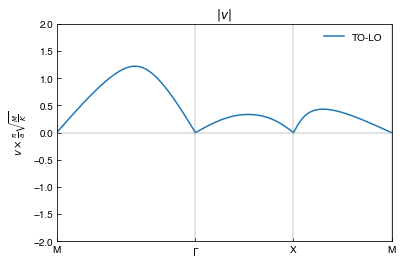

In [638]:
plt.figure(figsize=(6,3))
plt.plot(xq,np.sqrt(datav2[:,0,0,1].real**2+datav2[:,1,0,1].real**2),'-',label='TA-LA',lw=2) # 'b'   
plt.plot(xq,np.sqrt(datav2[:,0,0,2].real**2+datav2[:,1,0,2].real**2),'--',label='TA-TO',alpha=0.7) # 'b'    
plt.plot(xq,np.sqrt(datav2[:,0,0,3].real**2+datav2[:,1,0,3].real**2),'--',label='TA-LO',alpha=0.7) # 'b'    
plt.legend(ncol=4)
plt.axvline(xq[nq1//2],c='grey',alpha=0.3)
plt.axvline(xq[nq1],c='grey',alpha=0.3)
plt.axvline(xq[nq-1],c='grey',alpha=0.3)
plt.axhline(0,c='grey',alpha=0.3)
plt.xlim([0,xq[-1]])
plt.ylim([-2,2])
plt.title(r'$|v|$')
plt.xticks([xq[0], xq[nq1//2], xq[nq1],xq[nq-1]], ['M', '$\Gamma$', 'X','M'])
plt.ylabel(r'$v \times\frac{\pi}{a}\sqrt{\frac{M}{K}}$')
plt.figure()
plt.plot(xq,np.sqrt(datav2[:,0,1,2].real**2+datav2[:,1,1,2].real**2),'-',label='LA-TO') # 'b'    
plt.plot(xq,np.sqrt(datav2[:,0,1,3].real**2+datav2[:,1,1,3].real**2),'--',label='LA-LO',alpha=0.7) # 'b'    
plt.legend(ncol=4)
plt.axvline(xq[nq1//2],c='grey',alpha=0.3)
plt.axvline(xq[nq1],c='grey',alpha=0.3)
plt.axvline(xq[nq-1],c='grey',alpha=0.3)
plt.axhline(0,c='grey',alpha=0.3)
plt.xlim([0,xq[-1]])
plt.ylim([-2,2])
plt.title(r'$|v|$')
plt.xticks([xq[0], xq[nq1//2], xq[nq1],xq[nq-1]], ['M', '$\Gamma$', 'X','M'])
plt.ylabel(r'$v \times\frac{\pi}{a}\sqrt{\frac{M}{K}}$')
plt.figure()
plt.plot(xq,np.sqrt(datav2[:,0,2,3].real**2+datav2[:,1,2,3].real**2),'-',label='TO-LO') # 'b'    
plt.legend(ncol=4)
plt.axvline(xq[nq1//2],c='grey',alpha=0.3)
plt.axvline(xq[nq1],c='grey',alpha=0.3)
plt.axvline(xq[nq-1],c='grey',alpha=0.3)
plt.axhline(0,c='grey',alpha=0.3)
plt.xlim([0,xq[-1]])
plt.ylim([-2,2])
plt.title(r'$|v|$')
plt.ylabel(r'$v \times\frac{\pi}{a}\sqrt{\frac{M}{K}}$')
plt.xticks([xq[0], xq[nq1//2], xq[nq1],xq[nq-1]], ['M', '$\Gamma$', 'X','M'])

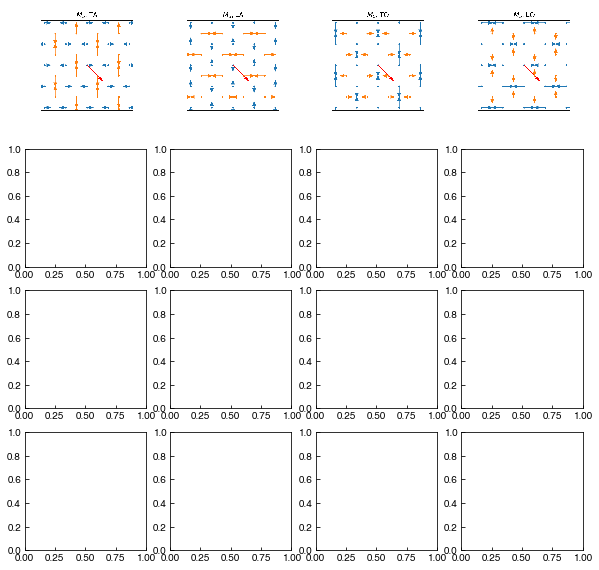

In [547]:
fig = plt.figure(figsize=(10,10))
fig.patch.set_visible(False)  
ax = fig.subplots(nrows=4, ncols=4)
fn = [['M_551TA.png','M_552LA.png','M_553TO.png','M_554LO.png']]
for i in range(1):
    for j in range(4):
        ax[i,j].axis('off')
        imgplot = ax[i,j].imshow(plt.imread(fn[i][j]))

In [635]:
def gen_dyn(force_constant,pos,pos_fc,q1):
    npos = len(pos)
    nd = 2*npos
    dyn = np.zeros((nd,nd),dtype=complex)
    nuc = len(pos)
    nsc = len(pos_fc)
    # central unit celll
    istart = int(1 * (3*nuc) + 1*nuc)

    for i in range(nuc):
        for j in range(nsc):
            for ix in range(2):
                for iy in range(2):
                    dyn[2*i+ix,2*np.mod(j,nuc)+iy] += \
                    force_constant[2*i+ix,2*j+iy]*\
                    np.exp(1j*(np.dot(q1,pos_fc[j,0:2]-pos_fc[istart+i,0:2])))\
                    /np.sqrt(pos[i,2]*pos[np.mod(j,nuc),2])
                    #print(pos[i,2]*pos[np.mod(j,nuc),2])
    #fig, axs = plt.subplots(ncols=1,figsize=(4,4))
    #matshow(axs,dyn.real,title='$fc$')
    print(dyn)
    return dyn


dnn = gen_dyn(force_constant,pos,pos_fc,[0.1,0.1])
dnn = gen_dyn(force_constant,pos,pos_fc,[-0.1,-0.1])
print(q[nq1],qq[nq1])
dnn = gen_dyn(force_constant,pos,pos_fc,[q[nq1]-0.01,qq[nq1]+0.01])
#dnn1 = gen_dyn(force_constant,pos,pos_fc,[q[nq1]+0.01,qq[nq1]-0.01])
dnn1 = gen_dyn(force_constant,pos,pos_fc,[-q[nq1]-0.01,-qq[nq1]+0.01])
print(dnn-dnn.T)
print(dnn-dnn1)

[[103.9469503 +0.j   3.9469503 +0.j -61.37414979+0.j   0.        +0.j]
 [  3.9469503 +0.j 103.9469503 +0.j   0.        +0.j -61.37414979+0.j]
 [-61.37414979+0.j   0.        +0.j  40.76350992+0.j   1.54782365+0.j]
 [  0.        +0.j -61.37414979+0.j   1.54782365+0.j  40.76350992+0.j]]
[[103.9469503 +0.j   3.9469503 +0.j -61.37414979+0.j   0.        +0.j]
 [  3.9469503 +0.j 103.9469503 +0.j   0.        +0.j -61.37414979+0.j]
 [-61.37414979+0.j   0.        +0.j  40.76350992+0.j   1.54782365+0.j]
 [  0.        +0.j -61.37414979+0.j   1.54782365+0.j  40.76350992+0.j]]
0.7853981633974483 0.7853981633974483
[[200.03999467+4.70074711e-17j  99.96000533+4.70074711e-17j
   -1.25236509+0.00000000e+00j   0.        +0.00000000e+00j]
 [ 99.96000533+4.70074711e-17j 200.03999467+4.70074711e-17j
    0.        +0.00000000e+00j   1.25236509+0.00000000e+00j]
 [ -1.25236509+0.00000000e+00j   0.        +0.00000000e+00j
   78.44705673+2.06112103e-17j  39.20000209+2.06112103e-17j]
 [  0.        +0.00000000e+00